# Option Viz — Data Layer Validation

This notebook exercises the **data/** modules you added:
- `base.py`, `registry.py`
- `yf_fetcher.py` (equities via yfinance)
- `okx_fetcher.py` (crypto via OKX; public endpoints by default; optional private signing)
- `cache.py`, `historical_loader.py`, `risk_free.py`, `rate_limit.py`

Run each section to confirm the modules behave as expected.

## 0) Setup: PYTHONPATH and environment

In [1]:
import os, sys
from pathlib import Path

# Add `src` to PYTHONPATH so `from data...` imports work.
repo_root = Path.cwd()
if (repo_root / "src").exists():
    sys.path.append(str(repo_root / "src"))
elif (repo_root.parent / "src").exists():
    sys.path.append(str(repo_root.parent / "src"))
else:
    sys.path.append(str(repo_root))

print(
    "PYTHONPATH entries now include:",
    [p for p in sys.path if p.endswith("src") or p.endswith("option-density-viz")],
)

# Optional: load .env for OKX private endpoints (not required for public data)
try:
    from dotenv import load_dotenv

    load_dotenv()
    print("Loaded .env (if present).")
except Exception as e:
    print("python-dotenv not installed or .env not found:", e)

PYTHONPATH entries now include: ['C:\\Users\\drewv\\Documents\\option-density-viz', 'c:\\Users\\drewv\\Documents\\option-density-viz\\src']
Loaded .env (if present).


## 1) Imports

In [2]:
import asyncio
from datetime import datetime, timezone
import pandas as pd
import matplotlib.pyplot as plt

from data.base import OptionChain, OptionQuote
from data.registry import get_fetcher
from data.yf_fetcher import YFinanceFetcher
from data.okx_fetcher import OKXFetcher
from data.historical_loader import chain_to_dataframe, save_chain_csv, load_chain_csv
from data.cache import KVCache, CacheConfig
from data.risk_free import RiskFreeProvider, RiskFreeConfig
from data.rate_limit import AsyncRateLimiter, retry_with_backoff

print("Imports successful.")

Imports successful.


## 2) Plot helpers (simple, matplotlib only)

In [3]:
def plot_mid_vs_strike(df: pd.DataFrame, title: str):
    d = df.copy()
    if "mid" not in d.columns:

        def _mid(row):
            b, a = row.get("bid"), row.get("ask")
            if b is not None and a is not None:
                return 0.5 * (b + a)
            return b if a is None else a

        d["mid"] = d.apply(_mid, axis=1)
    d = d[d["mid"].notna()].sort_values("strike")
    if d.empty:
        print("No mid prices to plot.")
        return
    plt.figure()
    plt.plot(d["strike"], d["mid"], marker="o")
    plt.title(title)
    plt.xlabel("Strike")
    plt.ylabel("Mid Price")
    plt.grid(True)
    plt.show()

## 3) Equity backend test (yfinance)

Found 28 expiries for SPY: ['2025-09-08', '2025-09-09', '2025-09-10', '2025-09-11', '2025-09-12'] ...
Quotes: 63 | Spot: 647.24 | AsOf: 2025-09-06T05:57:53.116789+00:00


,symbol,underlying,asset_class,expiry,strike,type,bid,ask,last,mark,volume,open_interest,contract_size,underlying_ccy,quote_ccy,is_inverse,iv,asof_utc,spot
0,SPY250908C00570000,SPY,equity,2025-09-08 00:00:00+00:00,570.0,C,75.56,78.36,81.92,None,1.0,2.0,100.0,USD,USD,False,0.875978,2025-09-06 05:57:53.116789+00:00,647.24
1,SPY250908C00580000,SPY,equity,2025-09-08 00:00:00+00:00,580.0,C,65.56,68.37,66.42,None,428.0,1.0,100.0,USD,USD,False,0.780276,2025-09-06 05:57:53.116789+00:00,647.24
2,SPY250908C00585000,SPY,equity,2025-09-08 00:00:00+00:00,585.0,C,60.56,63.37,61.83,None,115.0,2.0,100.0,USD,USD,False,0.731448,2025-09-06 05:57:53.116789+00:00,647.24
3,SPY250908C00590000,SPY,equity,2025-09-08 00:00:00+00:00,590.0,C,55.56,58.37,55.53,None,100.0,0.0,100.0,USD,USD,False,0.682620,2025-09-06 05:57:53.116789+00:00,647.24
4,SPY250908C00600000,SPY,equity,2025-09-08 00:00:00+00:00,600.0,C,45.57,48.38,46.98,None,4.0,12.0,100.0,USD,USD,False,0.585453,2025-09-06 05:57:53.116789+00:00,647.24
5,SPY250908C00605000,SPY,equity,2025-09-08 00:00:00+00:00,605.0,C,40.57,43.38,41.64,None,7.0,22.0,100.0,USD,USD,False,0.535649,2025-09-06 05:57:53.116789+00:00,647.24
6,SPY250908C00610000,SPY,equity,2025-09-08 00:00:00+00:00,610.0,C,35.58,38.38,36.99,None,14.0,22.0,100.0,USD,USD,False,0.485357,2025-09-06 05:57:53.116789+00:00,647.24
7,SPY250908C00615000,SPY,equity,2025-09-08 00:00:00+00:00,615.0,C,30.58,33.39,31.66,None,19.0,38.0,100.0,USD,USD,False,0.435553,2025-09-06 05:57:53.116789+00:00,647.24
8,SPY250908C00620000,SPY,equity,2025-09-08 00:00:00+00:00,620.0,C,25.58,28.39,27.01,None,49.0,55.0,100.0,USD,USD,False,0.383917,2025-09-06 05:57:53.116789+00:00,647.24
9,SPY250908C00625000,SPY,equity,2025-09-08 00:00:00+00:00,625.0,C,20.61,23.37,20.77,None,166.0,300.0,100.0,USD,USD,False,0.329352,2025-09-06 05:57:53.116789+00:00,647.24


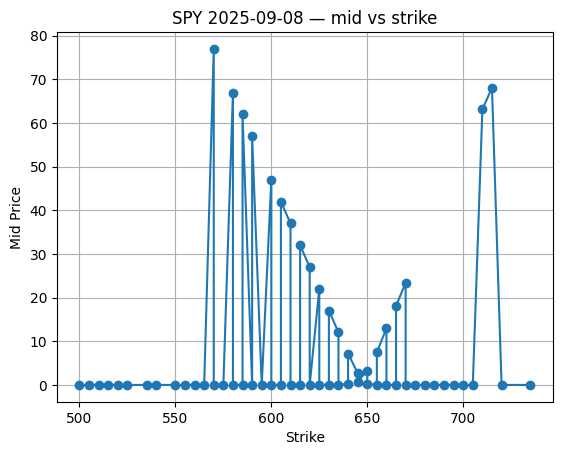

Reloaded chain quotes: 63


(                symbol underlying asset_class                    expiry  \
 0   SPY250908C00570000        SPY      equity 2025-09-08 00:00:00+00:00   
 1   SPY250908C00580000        SPY      equity 2025-09-08 00:00:00+00:00   
 2   SPY250908C00585000        SPY      equity 2025-09-08 00:00:00+00:00   
 3   SPY250908C00590000        SPY      equity 2025-09-08 00:00:00+00:00   
 4   SPY250908C00600000        SPY      equity 2025-09-08 00:00:00+00:00   
 ..                 ...        ...         ...                       ...   
 58  SPY250908P00660000        SPY      equity 2025-09-08 00:00:00+00:00   
 59  SPY250908P00665000        SPY      equity 2025-09-08 00:00:00+00:00   
 60  SPY250908P00670000        SPY      equity 2025-09-08 00:00:00+00:00   
 61  SPY250908P00710000        SPY      equity 2025-09-08 00:00:00+00:00   
 62  SPY250908P00715000        SPY      equity 2025-09-08 00:00:00+00:00   
 
     strike type    bid    ask   last  mark  volume  open_interest  \
 0    570.0    C

In [4]:
async def test_equity(
    underlying: str = "AAPL", expiry_index: int = 0, out_dir: str = "out"
):
    yf = YFinanceFetcher()
    expiries = await yf.list_expiries(underlying)
    if not expiries:
        raise RuntimeError(f"No expiries found for {underlying}")
    print(
        f"Found {len(expiries)} expiries for {underlying}: {[e.date().isoformat() for e in expiries[:5]]} ..."
    )
    expiry = expiries[expiry_index]
    chain = await yf.fetch_chain(underlying, expiry)
    df = chain_to_dataframe(chain)
    print(
        f"Quotes: {len(df)} | Spot: {chain.spot} | AsOf: {chain.asof_utc.isoformat()}"
    )
    display(df.head(10))
    plot_mid_vs_strike(df, f"{underlying} {expiry.date().isoformat()} — mid vs strike")
    # Save and reload
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    csv_path = Path(out_dir) / f"{underlying}_{expiry.date().isoformat()}_yf_chain.csv"
    save_chain_csv(csv_path, chain)
    loaded = load_chain_csv(csv_path)
    print("Reloaded chain quotes:", len(loaded.quotes))
    return df, chain


# Example:
await test_equity("SPY", 0)

## 4) Crypto backend test (OKX public endpoints)

Found 12 expiries for BTC: ['2025-09-06', '2025-09-07', '2025-09-08', '2025-09-09', '2025-09-12', '2025-09-19', '2025-09-26', '2025-10-31'] ...
Quotes: 54 | Spot: 110731.6 | AsOf: 2025-09-06T05:58:09.192830+00:00


,symbol,underlying,asset_class,expiry,strike,type,bid,ask,last,mark,volume,open_interest,contract_size,underlying_ccy,quote_ccy,is_inverse,iv,asof_utc,spot
0,BTC-USD-250906-100000-C,BTC,crypto,2025-09-06 00:00:00+00:00,100000.0,C,0.096,0.0975,0.0975,None,890.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
1,BTC-USD-250906-100000-P,BTC,crypto,2025-09-06 00:00:00+00:00,100000.0,P,NaN,0.0002,0.0002,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
2,BTC-USD-250906-102000-C,BTC,crypto,2025-09-06 00:00:00+00:00,102000.0,C,0.078,0.0795,0.0925,None,460.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
3,BTC-USD-250906-102000-P,BTC,crypto,2025-09-06 00:00:00+00:00,102000.0,P,NaN,0.0002,0.0001,None,238.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
4,BTC-USD-250906-104000-C,BTC,crypto,2025-09-06 00:00:00+00:00,104000.0,C,0.060,0.0615,NaN,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
5,BTC-USD-250906-104000-P,BTC,crypto,2025-09-06 00:00:00+00:00,104000.0,P,NaN,0.0002,0.0001,None,1109.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
6,BTC-USD-250906-105000-C,BTC,crypto,2025-09-06 00:00:00+00:00,105000.0,C,0.051,0.0525,NaN,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
7,BTC-USD-250906-105000-P,BTC,crypto,2025-09-06 00:00:00+00:00,105000.0,P,NaN,0.0001,0.0001,None,5172.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
8,BTC-USD-250906-106000-C,BTC,crypto,2025-09-06 00:00:00+00:00,106000.0,C,0.042,0.0435,NaN,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6
9,BTC-USD-250906-106000-P,BTC,crypto,2025-09-06 00:00:00+00:00,106000.0,P,NaN,0.0002,0.0002,None,6423.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:09.192830+00:00,110731.6


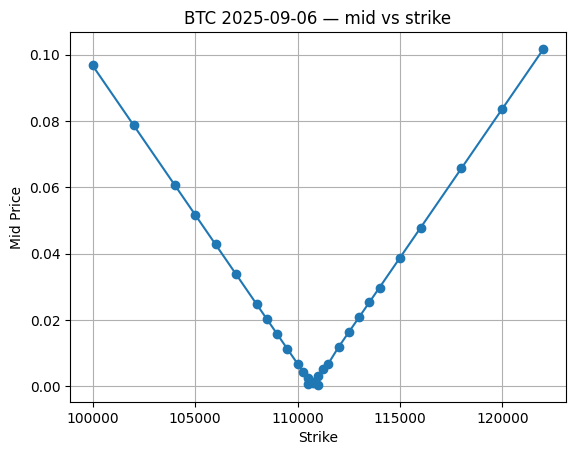

Reloaded chain quotes: 54


(                     symbol underlying asset_class                    expiry  \
 0   BTC-USD-250906-100000-C        BTC      crypto 2025-09-06 00:00:00+00:00   
 1   BTC-USD-250906-100000-P        BTC      crypto 2025-09-06 00:00:00+00:00   
 2   BTC-USD-250906-102000-C        BTC      crypto 2025-09-06 00:00:00+00:00   
 3   BTC-USD-250906-102000-P        BTC      crypto 2025-09-06 00:00:00+00:00   
 4   BTC-USD-250906-104000-C        BTC      crypto 2025-09-06 00:00:00+00:00   
 5   BTC-USD-250906-104000-P        BTC      crypto 2025-09-06 00:00:00+00:00   
 6   BTC-USD-250906-105000-C        BTC      crypto 2025-09-06 00:00:00+00:00   
 7   BTC-USD-250906-105000-P        BTC      crypto 2025-09-06 00:00:00+00:00   
 8   BTC-USD-250906-106000-C        BTC      crypto 2025-09-06 00:00:00+00:00   
 9   BTC-USD-250906-106000-P        BTC      crypto 2025-09-06 00:00:00+00:00   
 10  BTC-USD-250906-107000-C        BTC      crypto 2025-09-06 00:00:00+00:00   
 11  BTC-USD-250906-107000-P

In [5]:
async def test_crypto(
    underlying: str = "BTC", expiry_index: int = 0, out_dir: str = "out"
):
    okx = OKXFetcher()  # public endpoints do not require credentials
    expiries = await okx.list_expiries(underlying)
    if not expiries:
        raise RuntimeError(f"No expiries found for {underlying}")
    print(
        f"Found {len(expiries)} expiries for {underlying}: {[e.date().isoformat() for e in expiries[:8]]} ..."
    )
    expiry = expiries[expiry_index]
    chain = await okx.fetch_chain(underlying, expiry)
    df = chain_to_dataframe(chain)
    print(
        f"Quotes: {len(df)} | Spot: {chain.spot} | AsOf: {chain.asof_utc.isoformat()}"
    )
    display(df.head(10))
    plot_mid_vs_strike(df, f"{underlying} {expiry.date().isoformat()} — mid vs strike")
    # Save and reload
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    csv_path = Path(out_dir) / f"{underlying}_{expiry.date().isoformat()}_okx_chain.csv"
    save_chain_csv(csv_path, chain)
    loaded = load_chain_csv(csv_path)
    print("Reloaded chain quotes:", len(loaded.quotes))
    return df, chain


# Example:
await test_crypto("BTC", 0)

## 5) Cache demo (KVCache)

In [6]:
import time
from pathlib import Path

cache = KVCache(CacheConfig())

_counter = {"n": 0}


async def _expensive_fetch():
    await asyncio.sleep(0.2)  # pretend to hit a slow API
    _counter["n"] += 1
    return {"value": time.time(), "call_num": _counter["n"]}


async def cache_demo():
    key = "demo:slow"
    t0 = time.time()
    v1 = await cache.get_cached(key, _expensive_fetch, ttl_seconds=5.0)
    t1 = time.time()
    v2 = await cache.get_cached(key, _expensive_fetch, ttl_seconds=5.0)
    t2 = time.time()
    print("First call:", v1, "elapsed", round(t1 - t0, 3), "s")
    print("Second call (cached):", v2, "elapsed", round(t2 - t1, 3), "s")
    print("Calls actually executed:", _counter["n"])


# Example:
# await cache_demo()

## 6) Risk-free provider test (SOFR CSV + fallback)

In [7]:
import pandas as pd
from datetime import timedelta

# Create a small SOFR sample CSV on the fly
sofr_path = Path("out/sofr_sample.csv")
sofr_path.parent.mkdir(parents=True, exist_ok=True)
df_sofr = pd.DataFrame(
    {
        "date": pd.date_range("2025-01-01", periods=5, freq="D").date,
        "rate": [0.0520, 0.0521, 0.0522, 0.0525, 0.0524],
    }
)
df_sofr.to_csv(sofr_path, index=False)

rf = RiskFreeProvider(
    RiskFreeConfig(sofr_csv_path=sofr_path, default_rate=0.05, forward_fill=True)
)
d0 = datetime(2025, 1, 1)
print("r(d0):", rf.get_rate(d0))
print("r(d0+2):", rf.get_rate(d0 + timedelta(days=2)))
print("r(before range):", rf.get_rate(datetime(2024, 12, 25)))
print("r(after range):", rf.get_rate(datetime(2025, 12, 31)))

r(d0): 0.052
r(d0+2): 0.0522
r(before range): 0.052
r(after range): 0.0524


## 7) Rate limit + retry demo

In [8]:
from typing import Any

limiter = AsyncRateLimiter(max_concurrent=3)


class Flaky:
    def __init__(self, fail_times: int = 2):
        self.remaining = fail_times

    async def call(self) -> str:
        await asyncio.sleep(0.05)
        if self.remaining > 0:
            self.remaining -= 1
            raise RuntimeError("temporary failure")
        return "ok"


async def one_task(i: int) -> str:
    f = Flaky(fail_times=2)

    async def _op():
        return await f.call()

    result = await retry_with_backoff(_op, retries=5, base_delay=0.05, max_delay=0.2)
    return f"task {i}: {result}"


async def run_many(n: int = 10):
    async def _wrapped(i: int):
        return await limiter.run(lambda: one_task(i))

    results = await asyncio.gather(*[_wrapped(i) for i in range(n)])
    print("\\n".join(results))


# Example:
await run_many(10)

task 0: ok\ntask 1: ok\ntask 2: ok\ntask 3: ok\ntask 4: ok\ntask 5: ok\ntask 6: ok\ntask 7: ok\ntask 8: ok\ntask 9: ok


## 8) Runner — uncomment what you want to test

Found 20 expiries for AAPL: ['2025-09-12', '2025-09-19', '2025-09-26', '2025-10-03', '2025-10-10'] ...
Quotes: 85 | Spot: 239.69 | AsOf: 2025-09-06T05:58:11.188583+00:00


,symbol,underlying,asset_class,expiry,strike,type,bid,ask,last,mark,volume,open_interest,contract_size,underlying_ccy,quote_ccy,is_inverse,iv,asof_utc,spot
0,AAPL250912C00110000,AAPL,equity,2025-09-12 00:00:00+00:00,110.0,C,129.30,130.10,129.25,None,NaN,4.0,100.0,USD,USD,False,1.812501,2025-09-06 05:58:11.188583+00:00,239.69
1,AAPL250912C00130000,AAPL,equity,2025-09-12 00:00:00+00:00,130.0,C,109.25,110.50,106.45,None,3.0,4.0,100.0,USD,USD,False,1.941407,2025-09-06 05:58:11.188583+00:00,239.69
2,AAPL250912C00140000,AAPL,equity,2025-09-12 00:00:00+00:00,140.0,C,99.25,100.50,93.65,None,2.0,1.0,100.0,USD,USD,False,1.726564,2025-09-06 05:58:11.188583+00:00,239.69
3,AAPL250912C00150000,AAPL,equity,2025-09-12 00:00:00+00:00,150.0,C,89.40,90.15,90.35,None,2.0,2.0,100.0,USD,USD,False,1.382816,2025-09-06 05:58:11.188583+00:00,239.69
4,AAPL250912C00160000,AAPL,equity,2025-09-12 00:00:00+00:00,160.0,C,79.25,80.25,77.89,None,1.0,1.0,100.0,USD,USD,False,1.160160,2025-09-06 05:58:11.188583+00:00,239.69
5,AAPL250912C00175000,AAPL,equity,2025-09-12 00:00:00+00:00,175.0,C,64.35,65.60,58.47,None,1.0,4.0,100.0,USD,USD,False,1.143559,2025-09-06 05:58:11.188583+00:00,239.69
6,AAPL250912C00180000,AAPL,equity,2025-09-12 00:00:00+00:00,180.0,C,59.30,60.15,59.20,None,7.0,167.0,100.0,USD,USD,False,0.796877,2025-09-06 05:58:11.188583+00:00,239.69
7,AAPL250912C00185000,AAPL,equity,2025-09-12 00:00:00+00:00,185.0,C,54.35,55.15,43.37,None,2.0,49.0,100.0,USD,USD,False,0.777346,2025-09-06 05:58:11.188583+00:00,239.69
8,AAPL250912C00190000,AAPL,equity,2025-09-12 00:00:00+00:00,190.0,C,49.30,50.15,49.61,None,2.0,171.0,100.0,USD,USD,False,0.660160,2025-09-06 05:58:11.188583+00:00,239.69
9,AAPL250912C00195000,AAPL,equity,2025-09-12 00:00:00+00:00,195.0,C,44.35,45.15,44.88,None,4.0,296.0,100.0,USD,USD,False,0.632816,2025-09-06 05:58:11.188583+00:00,239.69


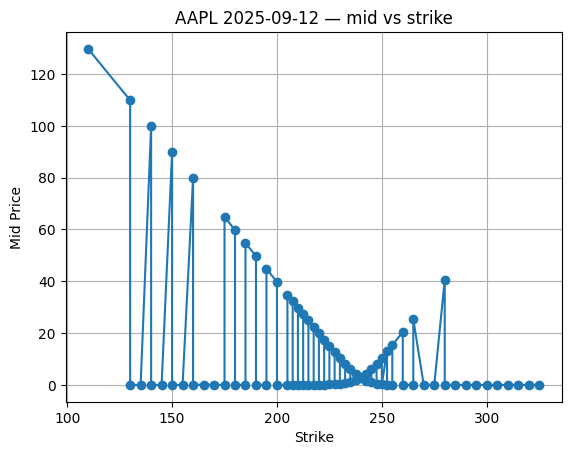

Reloaded chain quotes: 85
Found 12 expiries for BTC: ['2025-09-06', '2025-09-07', '2025-09-08', '2025-09-09', '2025-09-12', '2025-09-19', '2025-09-26', '2025-10-31'] ...
Quotes: 54 | Spot: 110727.7 | AsOf: 2025-09-06T05:58:26.407792+00:00


,symbol,underlying,asset_class,expiry,strike,type,bid,ask,last,mark,volume,open_interest,contract_size,underlying_ccy,quote_ccy,is_inverse,iv,asof_utc,spot
0,BTC-USD-250906-100000-C,BTC,crypto,2025-09-06 00:00:00+00:00,100000.0,C,0.096,0.0975,0.0975,None,890.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
1,BTC-USD-250906-100000-P,BTC,crypto,2025-09-06 00:00:00+00:00,100000.0,P,NaN,0.0002,0.0002,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
2,BTC-USD-250906-102000-C,BTC,crypto,2025-09-06 00:00:00+00:00,102000.0,C,0.078,0.0795,0.0925,None,460.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
3,BTC-USD-250906-102000-P,BTC,crypto,2025-09-06 00:00:00+00:00,102000.0,P,NaN,0.0002,0.0001,None,238.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
4,BTC-USD-250906-104000-C,BTC,crypto,2025-09-06 00:00:00+00:00,104000.0,C,0.060,0.0615,NaN,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
5,BTC-USD-250906-104000-P,BTC,crypto,2025-09-06 00:00:00+00:00,104000.0,P,NaN,0.0002,0.0001,None,1109.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
6,BTC-USD-250906-105000-C,BTC,crypto,2025-09-06 00:00:00+00:00,105000.0,C,0.051,0.0525,NaN,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
7,BTC-USD-250906-105000-P,BTC,crypto,2025-09-06 00:00:00+00:00,105000.0,P,NaN,0.0001,0.0001,None,5172.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
8,BTC-USD-250906-106000-C,BTC,crypto,2025-09-06 00:00:00+00:00,106000.0,C,0.042,0.0435,NaN,None,0.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7
9,BTC-USD-250906-106000-P,BTC,crypto,2025-09-06 00:00:00+00:00,106000.0,P,NaN,0.0002,0.0002,None,6422.0,None,1.0,USD,USDT,False,None,2025-09-06 05:58:26.407792+00:00,110727.7


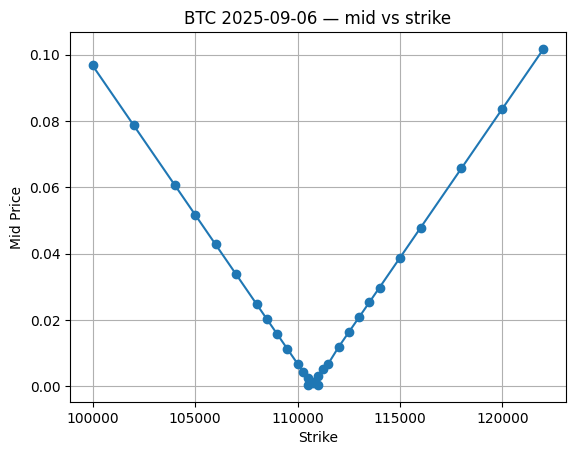

Reloaded chain quotes: 54
First call: {'value': 1757138306.7322345, 'call_num': 1} elapsed 0.218 s
Second call (cached): {'value': 1757138306.7322345, 'call_num': 1} elapsed 0.0 s
Calls actually executed: 1
task 0: ok\ntask 1: ok\ntask 2: ok\ntask 3: ok\ntask 4: ok\ntask 5: ok\ntask 6: ok\ntask 7: ok\ntask 8: ok\ntask 9: ok


In [9]:
# Equity:
await test_equity("AAPL", 0)

# Crypto (public):
await test_crypto("BTC", 0)

# Cache demo:
await cache_demo()

# Rate limit + retry:
await run_many(10)